In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/Shareddrives/Personal/INR/Playground/Wire Implementation'

## Code

In [46]:
import os
from tqdm import tqdm
import time
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn
from torch.optim.lr_scheduler import LambdaLR
from modules import models
from modules import utils

In [47]:
torch.cuda.set_device(1)

In [48]:
T0 = 0.4
b0 = 0.4
noisy = True
nonlin = 'raisedCos'            # type of nonlinearity, 'wire', 'siren', 'mfn', 'relu', 'posenc', 'gauss'
niters = 2000               # Number of SGD iterations
learning_rate = 5e-3        # Learning rate.

    # WIRE works best at 5e-3 to 2e-2, Gauss and SIREN at 1e-3 - 2e-3,
# MFN at 1e-2 - 5e-2, and positional encoding at 5e-4 to 1e-3

tau = 3e1                   # Photon noise (max. mean lambda). Set to 3e7 for representation, 3e1 for denoising
noise_snr = 2               # Readout noise (dB)

# Gabor filter constants.
# We suggest omega0 = 4 and sigma0 = 4 for denoising, and omega0=20, sigma0=30 for image representation
omega0 = 4.0           # Frequency of sinusoid
sigma0 = 4.0           # Sigma of Gaussian

# Network parameters
hidden_layers = 3      # Number of hidden layers in the MLP
hidden_features = 256   # Number of hidden units per layer
maxpoints = 256*256     # Batch size


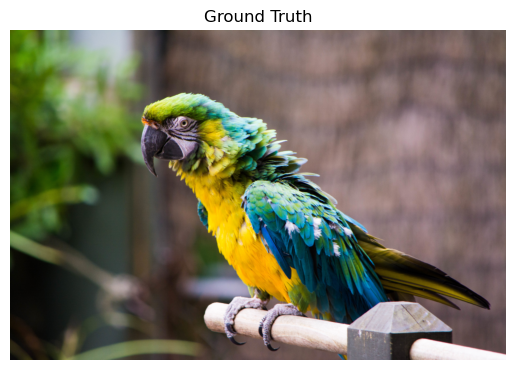

In [49]:
# Read image and scale. A scale of 0.5 for parrot image ensures that it
# fits in a 12GB GPU
im = utils.normalize(plt.imread('images/parrot.png').astype(np.float32), True)
im = cv2.resize(im, None, fx=1/2, fy=1/2, interpolation=cv2.INTER_AREA)
H, W, _ = im.shape

plt.imshow(im)
plt.title('Ground Truth')
plt.axis('off')  # Hide axis
plt.show()

In [50]:
# Create a noisy image
im_noisy = utils.measure(im, noise_snr, tau)

In [51]:
if nonlin == 'posenc':
    nonlin = 'relu'
    posencode = True

    if tau < 100:
        sidelength = int(max(H, W)/3)
    else:
        sidelength = int(max(H, W))

else:
    posencode = False
    sidelength = H

In [52]:
model = models.get_INR(
                    nonlin=nonlin,
                    in_features=2,
                    out_features=3,
                    hidden_features=hidden_features,
                    hidden_layers=hidden_layers,
                    first_omega_0=omega0,
                    hidden_omega_0=omega0,
                    beta0=b0,
                    T0=T0,
                    scale=sigma0,
                    pos_encode=posencode,
                    sidelength=sidelength)

    # Send model to CUDA
model.cuda()

print('Number of parameters: ', utils.count_parameters(model))
print('Input PSNR: %.2f dB'%utils.psnr(im, im_noisy))

Number of parameters:  198923
Input PSNR: 17.65 dB


In [53]:
# Create an optimizer
optim = torch.optim.Adam(lr=learning_rate*min(1, maxpoints/(H*W)),
                         params=model.parameters())

# Schedule to reduce lr to 0.1 times the initial rate in final epoch
scheduler = LambdaLR(optim, lambda x: 0.1**min(x/niters, 1))

In [54]:
x = torch.linspace(-1, 1, W)
y = torch.linspace(-1, 1, H)

X, Y = torch.meshgrid(x, y, indexing='xy')
coords = torch.hstack((X.reshape(-1, 1), Y.reshape(-1, 1)))[None, ...]

gt = torch.tensor(im).cuda().reshape(H*W, 3)[None, ...]
gt_noisy = torch.tensor(im_noisy).cuda().reshape(H*W, 3)[None, ...]

if noisy: img = gt_noisy
else: img = gt

mse_array = torch.zeros(niters, device='cuda')
mse_loss_array = torch.zeros(niters, device='cuda')
consts_b0 = []
consts_T0 = []
time_array = torch.zeros_like(mse_array)

best_mse = torch.tensor(float('inf'))
best_img = None

rec = torch.zeros_like(gt)

init_time = time.time()

In [55]:
tbar = tqdm(range(niters))
# -------------------------------- Training Loop ---------------------------------
for epoch in tbar:
    indices = torch.randperm(H*W)

    for b_idx in range(0, H*W, maxpoints):
        b_indices = indices[b_idx:min(H*W, b_idx+maxpoints)]
        b_coords = coords[:, b_indices, ...].cuda()
        b_indices = b_indices.cuda()
        pixelvalues = model(b_coords)

        with torch.no_grad():
            rec[:, b_indices, :] = pixelvalues

        loss = ((pixelvalues - img[:, b_indices, :])**2).mean()

        optim.zero_grad()
        loss.backward()
        optim.step()

    tbar.set_description(f'loss: {loss.item():.4f}')
    time_array[epoch] = time.time() - init_time

    with torch.no_grad():
        mse_loss_array[epoch] = ((img - rec)**2).mean().item()
        mse_array[epoch] = ((gt - rec)**2).mean().item()
        consts_b0.append([getattr(layer, 'beta0').cpu().item() for layer in model.net.modules() if hasattr(layer, 'beta0')])
        consts_T0.append([getattr(layer, 'T0').cpu().item() for layer in model.net.modules() if hasattr(layer, 'T0')])
        im_gt = gt.reshape(H, W, 3).permute(2, 0, 1)[None, ...]
        im_rec = rec.reshape(H, W, 3).permute(2, 0, 1)[None, ...]

        psnrval = -10*torch.log10(mse_array[epoch])
        tbar.set_description('%.1f'%psnrval)
        tbar.refresh()

    scheduler.step()

    imrec = rec[0, ...].reshape(H, W, 3).detach().cpu().numpy()

    if (mse_array[epoch] < best_mse) or (epoch == 0):
        best_img = imrec
        best_epoch = epoch

if posencode:
    nonlin = 'posenc'

# for noiseless training, mse_array and mse_noisy_array are same
mdict = {'rec': best_img, # a tupe with (imrec, best_mse, epoch)
         'epoch': best_epoch,
         'gt': im,
         'im_noisy': im_noisy,
         'mse_noisy_array': mse_loss_array.detach().cpu().numpy(),
         'mse_array': mse_array.detach().cpu().numpy(),
         'consts_array': (consts_b0,consts_T0), # (list with (beta0,T0)s)
         'time_array': time_array.detach().cpu().numpy()}

os.makedirs('results/denoising', exist_ok=True)
io.savemat(f"results/denoising/{nonlin}_T{T0}_b{b0}_noisy({noisy})_hiddenLayrs({hidden_layers}).mat", mdict)

print('Best PSNR: %.2f dB'%utils.psnr(im, best_img))

  0%|          | 0/2000 [00:00<?, ?it/s]

25.6: 100%|██████████| 2000/2000 [24:52<00:00,  1.34it/s]        

Best PSNR: 25.58 dB


## View Mat

In [56]:
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
from modules.utils import psnr


In [57]:
mats = io.loadmat(f"results/denoising/{nonlin}_T{T0}_b{b0}_noisy({noisy})_hiddenLayrs({hidden_layers}).mat")

In [58]:
mats.keys()

dict_keys(['__header__', '__version__', '__globals__', 'rec', 'epoch', 'gt', 'im_noisy', 'mse_noisy_array', 'mse_array', 'consts_array', 'time_array'])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.28272954..1.1390091].


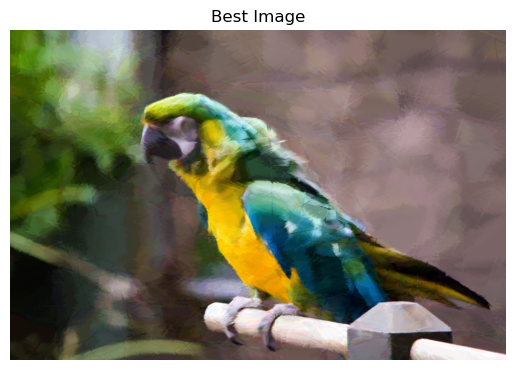

In [59]:
img = mats['rec']
plt.imshow(img)
plt.title('Best Image')
plt.axis('off')  # Hide axis
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.28272954..1.1390091].


(np.float64(-0.5), np.float64(1019.5), np.float64(677.5), np.float64(-0.5))

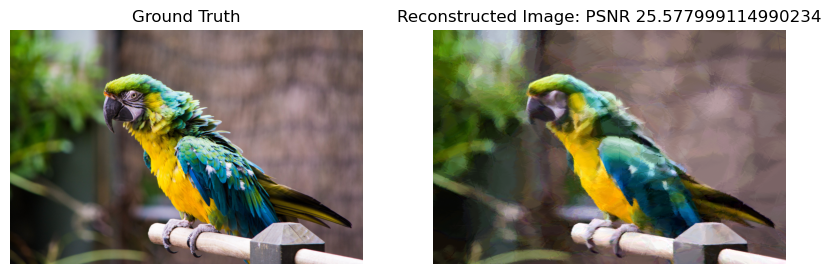

In [60]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display the first image
axes[0].imshow(im)
axes[0].set_title('Ground Truth')
axes[0].axis('off')  # Hide axis

# Display the second image
axes[1].imshow(img)
axes[1].set_title(f"Reconstructed Image: PSNR {round(utils.psnr(im, best_img), 3)}")
axes[1].axis('off')  # Hide axis

# Show the pl


In [61]:
print(f"PSNR added noise: {psnr(mats['gt'], mats['im_noisy']):.4f}")
print(f"PSNR reconstruction noise: {psnr(mats['gt'], mats['rec']):.4f}")

PSNR added noise: 17.6458
PSNR reconstruction noise: 25.5776


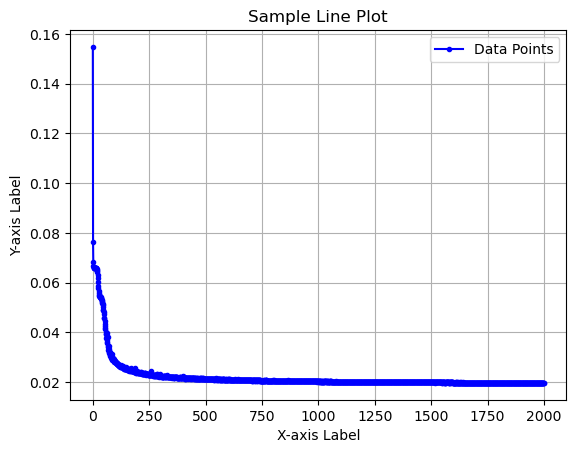

In [62]:
import matplotlib.pyplot as plt

# Sample data
x = np.arange(niters)
y = mats['mse_noisy_array'].reshape(-1,1)

# Create a line plot
plt.plot(x, y, marker='.', linestyle='-', color='b', label='Data Points')

# Adding labels and title
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Sample Line Plot')
plt.legend()
plt.grid()

# Show the plot
plt.show()
